## GLANCE: Global Actions In A Nutshell for Counterfactual Explainability

**GLANCE** is a versatile and adaptive framework for generating *global counterfactual explanations*. <br>
These explanations are expressed as actions that offer recourse to large population subgroups.<br> The framework aims to provide explanations and insights, ensuring that the actions benefit as many individuals as possible.

GLANCE consists of two algorithms: 

- **C-GLANCE** that employs a clustering-based approach, ideal for explaining and debugging the model
- **T-GLANCE** that employs a tree-based approach, ideal for policy-making and auditing.

In this notebook, we will explore how to use these algorithms effectively.

We will use the Adult Dataset from the UCI Machine Learning Repository ([reference](https://archive.ics.uci.edu/dataset/2/adult)).<br>
Adult Dataset is a widely used collection of demographic information derived from the 1994 U.S. Census database. It includes features such as age, work class,<br> education level, marital status, occupation, relationship, race, sex, hours worked per week and the target variable is whether an individual earns more than $50,000 per year,<br> making it a popular dataset for classification tasks in machine learning.


## Preliminaries

### Import Dependencies 
As usual in python, the first step is to import all necessary packages.



In [1]:
from xgboost import XGBClassifier
import pandas as pd
from aix360.algorithms.glance.iterative_merges.iterative_merges import C_GLANCE
from aix360.algorithms.glance.counterfactual_tree.counterfactual_tree import T_GLANCE
from aix360.datasets.adult_dataset import AdultDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import  OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

## Load Dataset


In [2]:
data = AdultDataset()
df = data.dataframe()
df.head()

Using Adult dataset:  c:\users\nikolastheol\documents\github\aix360\aix360\datasets\..\data\adult_data\adult.csv


,Age,Workclass,Fnlwgt,Education,Marital-Status,Occupation,Relationship,Race,Sex,Capital-Gain,Capital-Loss,Hours-Per-Week,Native-Country,Status
0,39,State-gov,77516,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


## Example Model to be used for explanations
We use the train set to train a simple XGBoostClassifier. This will serve as the demonstrative model, which we will then treat as a black box and apply our algorithm.

Of course, any model can be used in its place.



In [3]:
df = df.sample(frac=0.01, random_state=42)
X = df.drop(columns='Status')
y = df['Status']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=13)
num_features = X_train._get_numeric_data().columns.to_list()
cate_features = X_train.columns.difference(num_features)

In [4]:
model = XGBClassifier()
preprocessor = ColumnTransformer(
    transformers=[
        (
            "cat",
            OneHotEncoder(sparse_output=False, handle_unknown="ignore"),
            cate_features,
        )
    ],
    remainder="passthrough",
)
_model = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("classifier", model),
    ]
)
_model.fit(X_train,y_train)
predictions = _model.predict(X_test)

GLANCE focuses on the population that has obtained the unfavorable outcome (affected population) (affected population) by a ML model.<br> It aims to find the *s* global actions that, if applied, the specific population will achieve the favorable outcome.<br>
<br>
For this reason, our first step is to identify the affected population, as it serves as input to the algorithm.

In [5]:
affected = X_test[predictions == 0].reset_index(drop=True)
train_dataset = df.copy()


for col in num_features:
    train_dataset[col] = train_dataset[col].astype(float)

    
train_dataset["target"] = df['Status']
train_dataset.drop(columns='Status',inplace=True)

#feat_to_vary is a variable used by DiCE counterfactual explanation
feat_to_vary = list(affected.columns)
target_name = "Status"

## A Practical Example of GLANCE

### C-GLANCE (Iterative Merges)
C-GLANCE is a clustering-based approach for the implicit Global Counterfactual Explanation problem
that returns *s* global actions.<br>

C-GLANCE framework is loaded with:
 - the model to be explained
 - number of initial clusters
 - number of final clusters, e.g the number of actions to be generated at the end of the algorithm that corresponds to the *s* global actions
 - number of local counterfactuals, in order to generate candidate counterfactual explanations

In [17]:
global_method = C_GLANCE(
    _model, #model to be explained
    initial_clusters=40, #starting number of cluster
    final_clusters=3, #number of final clusters after merging, corresponds to the number of global actions
    num_local_counterfactuals=10, #number of counterfactuals the Local Counterfactual Method generates
)
global_method.fit(
    df.drop(columns=["Status"]),
    df["Status"],
    train_dataset,
    feat_to_vary, #DiCE parameter that chooses which features to change in order to generate counterfactuals
    cf_generator="Dice"
)

clusters, clusters_res = global_method.explain_group(affected)

100%|██████████| 1/1 [00:00<00:00,  2.01it/s]
c:\users\nikolastheol\documents\github\aix360\aix360\algorithms\glance\iterative_merges\iterative_merges.py:1034: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column_name, value in row['action'].to_frame().T.reset_index(drop=True).iteritems():


Action 1 
Occupation = Prof-specialty 
Capital-Gain +27653.8 

Effectiveness: 100.00%	Cost: 3.77


Action 2 
Fnlwgt +166477.90000000002 
Capital-Gain +22738.8 

Effectiveness: 100.00%	Cost: 3.51


Action 3 
Occupation = Prof-specialty 
Capital-Gain +22866.8 

Effectiveness: 100.00%	Cost: 3.29


TOTAL EFFECTIVENESS: 100.00%
TOTAL COST: 3.24


### C-GLANCE Output
C-GLANCE's output consists of the different actions generated based on the **final_clusters** variable and the respective metrics (*effectiveness*, *cost*) each action achieves.<br>
Starting from **n_initial_clusters** and after merging, our algorithm reaches the **final_clusters** specified and for each one the best action is extracted.

- *Effectiveness*, refers to how well the proposed changes (or actions) succeed in altering the unfavorable outcomes of an affected population.<br> In our case it is showcased as the percentage of the affected that achieved the favorable outcome 
<br><br>
- *Cost*, is the distance between the current state of the affected population and the state after applying the global actions,<br> reflecting how far (or how much) the population must shift to achieve a favorable outcome.

## C-GLANCE Modularity
Our framework is highly **modular**, allowing users to customize various aspects of it. <br>

Specifically:
- **Choice of Local Counterfactual Methods**: Users can select from a variety of local counterfactual methods to generate candidate counterfactual explanations, such as:
    - **NearestNeighbors**: When queried to provide *k* counterfactuals for an affected individual, it retrieves the k nearest neighbors from the set of unaffected instances based on their proximity to the affected individual.
    - **Random Sampling**: To find counterfactuals for an affected instance, this method iteratively modifies its features one at a time. The process begins by randomly altering one feature at a time, generating multiple new candidate instances

- **Strategy for Selecting Actions**: Additionally, users can choose different strategies for selecting the best actions from the generated counterfactuals. This enables fine-tuning of the process, allowing for the optimal balance between effectiveness and recourse cost, based on user-defined preferences.
    - **max-eff** : Selects actions based on maximizing the effectiveness.
    - **low-cost** : Selects the action with the lowest cost that flips a sufficient number of instances.
    - **mean-act** : Selects the mean action from a set of candidate actions.

In order to use them, the user should provide the **fit** method with the **cf_generator** and **cluster_action_choice_algo** variables and choose the methods of his/hers liking.

In [7]:
global_method = C_GLANCE(
    _model, initial_clusters=100, final_clusters=3, num_local_counterfactuals=10
)
global_method.fit(
    df.drop(columns=["Status"]),
    df["Status"],
    train_dataset,
    feat_to_vary,
    cluster_action_choice_algo = 'max-eff',
    cf_generator="RandomSampling",
)

In [8]:
clusters, clusters_res = global_method.explain_group(affected)

c:\users\nikolastheol\documents\github\aix360\aix360\algorithms\glance\iterative_merges\iterative_merges.py:294: UserWarning: Requested number of initial clusters is larger than the number of instances to explain. Setting to number of instances.
  warnings.warn(
c:\users\nikolastheol\documents\github\aix360\aix360\algorithms\glance\iterative_merges\iterative_merges.py:1034: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column_name, value in row['action'].to_frame().T.reset_index(drop=True).iteritems():


Action 1 
Occupation = Prof-specialty 
Capital-Gain +13557.188787639796 

Effectiveness: 100.00%	Cost: 2.36


Action 2 
Occupation = Prof-specialty 
Capital-Gain +20114.538415771953 

Effectiveness: 100.00%	Cost: 3.01


Action 3 
Education = Masters 
Capital-Gain +16663.340617145903 

Effectiveness: 100.00%	Cost: 2.67


TOTAL EFFECTIVENESS: 100.00%
TOTAL COST: 2.31


# T-GLANCE (Counterfactual Tree)
T-GLANCE is the second algorithm of the GLANCE framework that generates global counterfactual explanations using a decision tree-like structure.<br>
It allows users to specify split features, to build a decision tree with a single counterfactual action at each node that can be used as a subgroup policy.<br>

T-GLANCE framework is loaded with:
 - the model to be explained
 - split_features, the specified features to be used in the splits, if **None** we provide suggestions based feature permutation score of the features

T-GLANCE is also modular, as the user can specify the Local Counterfactual Explanation Method to be used as in C-GLANCE.

In [14]:
cf_tree = T_GLANCE(_model, split_features=None)
cf_tree.fit(X, y, train_dataset)
node = cf_tree.partition_group(affected)

100%|██████████| 1/1 [00:00<00:00,  2.01it/s]


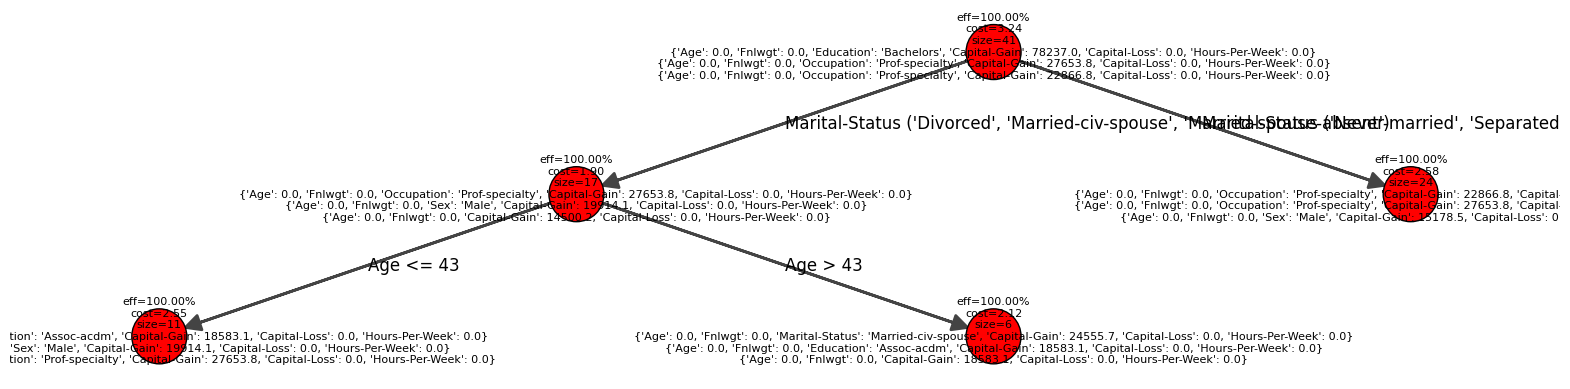

In [15]:
node.display_igraph_jupyter(
    numeric_features=affected.select_dtypes(
        include=["number"]).columns.tolist()
)

In [16]:
cf_tree.cumulative_leaf_actions()


TOTAL EFFECTIVENESS: 100.00%

TOTAL COST: 2.20


(41, 90.00454004540046, 9)